In [11]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [12]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


pickle files- searilzed-converts all objects to character strings

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical 
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import random
import pickle
import pandas as pd

In [14]:
np.random.seed()

Deserializing dataset with pickle


In [15]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))
X_train, y_train =train_data['features'], train_data['labels']
X_test, y_test =test_data['features'], test_data['labels']
X_val, y_val =val_data['features'], val_data['labels']

<class 'dict'>


In [16]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [17]:
assert(X_train.shape[0] == y_train.shape[0]),"the number of images is not equal to number of labels"
assert(X_test.shape[0] == y_test.shape[0]),"the number of images is not equal to number of labels"
assert(X_val.shape[0] == y_val.shape[0]),"the number of images is not equal to number of labels"
assert(X_train.shape[1:])==(32,32,3),"The dimension of images are not 32 x 32 x3"
assert(X_test.shape[1:])==(32,32,3),"The dimension of images are not 32 x 32 x3"
assert(X_val.shape[1:])==(32,32,3),"The dimension of images are not 32 x 32 x3"


In [18]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

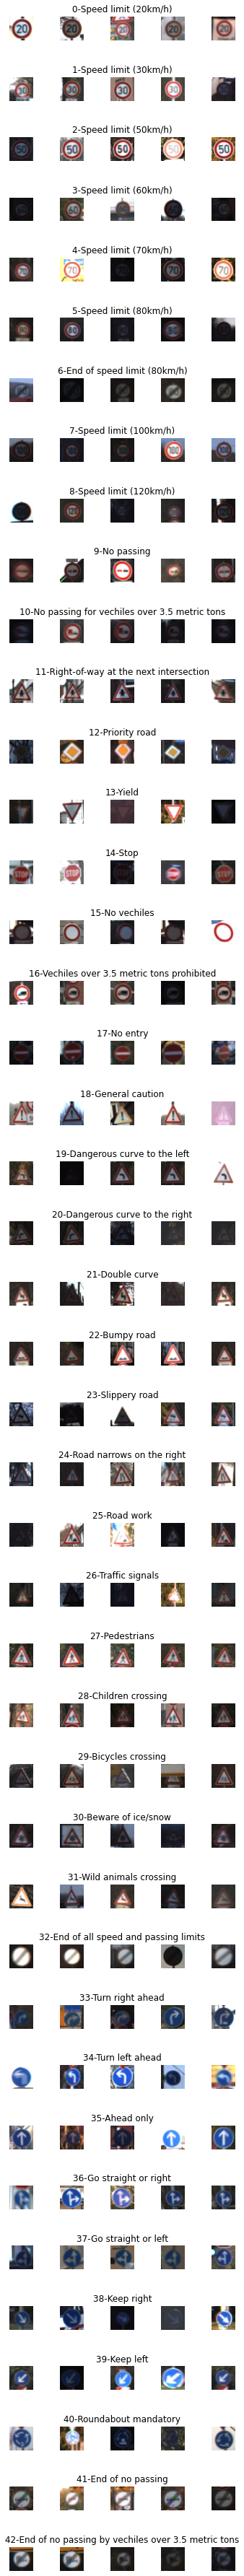

In [19]:
num_samples = []
cols = 5
num_classes = 43

fig,axs = plt.subplots(nrows=num_classes, ncols= cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,len(x_selected -1)),:,:],cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2 :
            axs[j][i].set_title(str(j)+"-"+row["SignName"])
            num_samples.append(len(x_selected))

  #(index,series)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0.5, 1.0, 'Distribution of training data set')

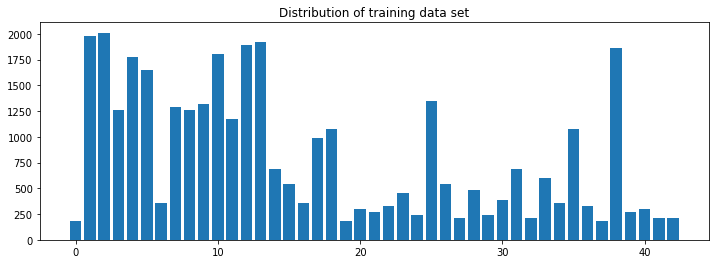

In [20]:
print(num_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_samples)
plt.title("Distribution of training data set")

**Preprocessing images for network to classify them**


(32, 32, 3)
31


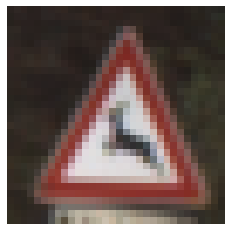

In [21]:
import cv2
plt.imshow(X_train[500])
plt.axis("off")
print(X_train[500].shape)
print(y_train[500])

Grayscaling

(32, 32)


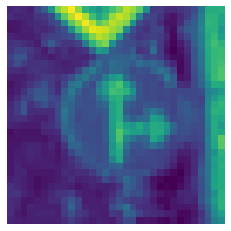

In [22]:
def grayscale(img): #depth reduced to 1 from 3 so require less computional power required to classify
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

Histogram Equalization- aims to standardize lighting in all images
some images- this procees helps to create similar lighting effect
high contrast-helps for feature extraction,
enhances contrast, 
helps in more uniform distribution of intensities

(-0.5, 31.5, 31.5, -0.5)

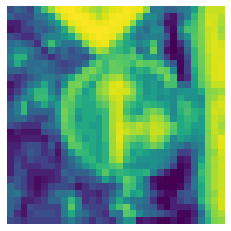

In [23]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")

to preproc.. all the images

In [24]:
def preprocessing(img):
  img= grayscale(img) #grascale
  img= equalize(img) #histo. equalization
  img= img/255 #normalization
  return img #preprocessed image
#Now run dataset through preprocessing
X_train= np.array(list(map(preprocessing, X_train))) #map returns as a list so use array
X_test= np.array(list(map(preprocessing, X_test)))
X_val= np.array(list(map(preprocessing, X_val)))

(34799, 32, 32)


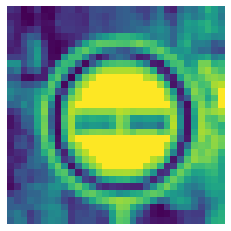

In [25]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)]) #shows random preprocessed image
plt.axis("off")
print(X_train.shape)

In [26]:
X_train=X_train.reshape(34799, 32, 32,1) #formatting i/p dataset to form our network CNN
X_test=X_test.reshape(12630, 32, 32, 1)
X_val=X_val.reshape(4410, 32, 32, 1)

print(X_train.shape,X_test.shape,X_val.shape)

(34799, 32, 32, 1) (12630, 32, 32, 1) (4410, 32, 32, 1)


In [27]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,#max horizontal shift posible is 10percent-0.1 of image width
                             height_shift_range=0.1,
                             zoom_range=0.2, #can zoom out as 0.6,zoom in 0.2
                             shear_range=0.1,
                             rotation_range=10)
datagen.fit(X_train)

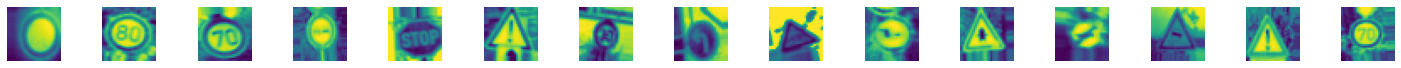

In [28]:
batches=datagen.flow(X_train,y_train, batch_size=20)#requesting image generator foro images
#stores a batch of 20 image along with respective labels
X_batch, y_batch = next(batches) 
fig,axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [29]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test,43)
y_val = to_categorical(y_val,43)

print(y_train.shape,y_test.shape,y_val.shape)

(34799, 43) (12630, 43) (4410, 43)


Defining LeNet model

In [30]:
def modified_model():
    model= Sequential()
    model.add(Conv2D(100,(5,5),input_shape=(32,32,1),activation='relu')) #32,32,1 image get reduced to 28,28,30 as o/p of this layer reduces to 28,28 for each feature map as convoluing 5,5 image with stride 1 we lose 2 pixel border at edge of imgae
   #5x5x30+30=780 adjustable parameters
    model.add(Conv2D(100,(5,5),activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2)))#pooling scales down all feature maps of conv layer into small abstracted genaralized representations which helps to avoid overfitting and reduce number of adjustable parameters

    model.add(Conv2D(50, (3,3), activation='relu'))
  #15*30*9=4050 parameters +15(bias)= 465 parametesr
    model.add(Conv2D(50, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten()) #converts/reshape to 1D array which are the inputs to fully connected network
    model.add(Dense(500,activation='relu')) #500-arbitary;lower no. can give less accuracy, higher no requires more computing power
    model.add(Dropout(0.5))#0-no ip nodes dropped,1-all ip nodes are dropped at each update effective way to prevent overfidding by adding more dropout layers
    model.add(Dense(num_classes, activation='softmax'))
  #compile model
    model.compile(Adam(0.001),loss= 'categorical_crossentropy', metrics=['accuracy'])
    return model

In [31]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 100)       2600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 100)       250100    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 50)        45050     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 50)          22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 50)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 50)          0

In [32]:
history= model.fit_generator(datagen.flow(X_train, y_train, batch_size=140),steps_per_epoch =200,epochs=25,validation_data=(X_val,y_val), verbose= 1, shuffle=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
200/200 [==============================] - 46s 81ms/step - loss: 2.7127 - accuracy: 0.2579 - val_loss: 0.9884 - val_accuracy: 0.7381
Epoch 2/25
200/200 [==============================] - 16s 78ms/step - loss: 1.1754 - accuracy: 0.6418 - val_loss: 0.3234 - val_accuracy: 0.9011
Epoch 3/25
200/200 [==============================] - 15s 75ms/step - loss: 0.7062 - accuracy: 0.7802 - val_loss: 0.1668 - val_accuracy: 0.9560
Epoch 4/25
200/200 [==============================] - 15s 76ms/step - loss: 0.5069 - accuracy: 0.8433 - val_loss: 0.0901 - val_accuracy: 0.9732
Epoch 5/25
200/200 [==============================] - 16s 79ms/step - loss: 0.4099 - accuracy: 0.8711 - val_loss: 0.0741 - val_accuracy: 0.9816
Epoch 6/25
200/200 [==============================] - 16s 79ms/step - loss: 0.3264 - accuracy: 0.8980 - val_loss: 0.0652 - val_accuracy: 0.9810
Epoch 7/25
200/200 [==============================] - 15s 77ms/step - loss: 0.2866 - accuracy: 0.9091 - val_loss: 0.0557 - val_accuracy:

Text(0.5, 0, 'epoch')

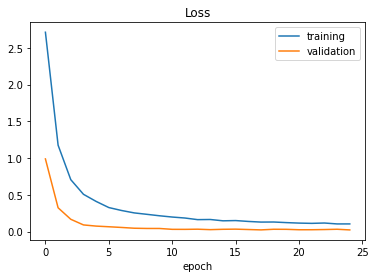

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

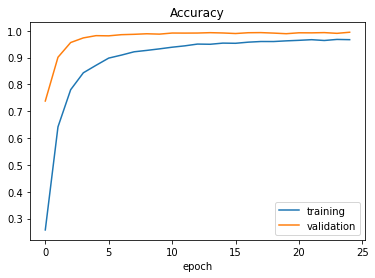

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [35]:
score=model.evaluate(X_test,y_test, verbose = 0)
print("Test score",score[0])
print("Test accuracy",score[1])

Test score 0.11195632070302963
Test accuracy 0.9735550284385681


<Response [200]>


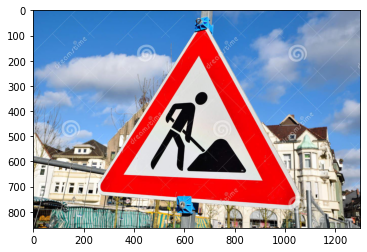

In [44]:
import requests
from PIL import Image
url ='https://raw.githubusercontent.com/dhnkrn/Traffic-Sign-Classifier/master/images/german_1.jpg'
response= requests.get(url, stream=True)
print(response)
img = Image.open(response.raw)
plt.imshow(img,cmap=plt.get_cmap('gray'))

(864, 1300, 3)
(32, 32)


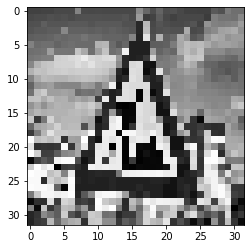

In [45]:
img = np.asarray(img)
print(img.shape)
import cv2 

img = cv2.resize(img,(32,32))
img = preprocessing(img)
plt.imshow(img,cmap = plt.get_cmap("gray"))
print(img.shape)

In [46]:
img = img.reshape(1,32,32,1)

In [47]:
print("Predicted sign:" + str(np.argmax(model.predict(img), axis=-1)))

Predicted sign:[25]


The predicted sign corresponds to class 3 which is for Road work

<Response [200]>


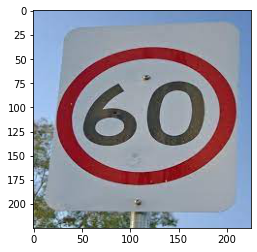

In [55]:
import requests
from PIL import Image
url ='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRKdahQ-r7D5MrPkzUnyvOAK_SYFfAMtTHwzbw2QCQOt_8eT-8WY7XsSGf48MzItq1u3TE&usqp=CAU'
response= requests.get(url, stream=True)
print(response)
img = Image.open(response.raw)
plt.imshow(img,cmap=plt.get_cmap('gray'))

(225, 225, 3)
(32, 32)


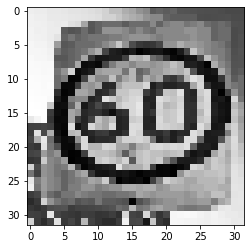

In [56]:
img = np.asarray(img)
print(img.shape)
import cv2 

img = cv2.resize(img,(32,32))
img = preprocessing(img)
plt.imshow(img,cmap = plt.get_cmap("gray"))
print(img.shape)

In [57]:
img = img.reshape(1,32,32,1)
print("Predicted sign:" + str(np.argmax(model.predict(img), axis=-1)))

Predicted sign:[3]


The predicted sign corresponds to class 3 which is for speen limit of 60

# New Section